# Iterative Construction of a Penalised Vine Structure
This notebook iteratively estimate the quantile.

#### Libraries

In [1]:
import openturns as ot
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

%load_ext autoreload
%autoreload 2

random_state = 123
np.random.seed(random_state)

#### Model function
This example consider the simple additive example.

In [2]:
from dependence.tests import func_overflow, margins_overflow, var_names_overflow, func_sum

test_func = func_overflow

#### Dimension and margins
We first define the problem dimension and the margins

In [3]:
if test_func == func_overflow:
    margins = margins_overflow
    dim = len(margins)
else:
    dim = 6
    margins = [ot.Normal()]*dim

We chose the coefficients of the variables throught the additive function.

In [4]:
if test_func == func_sum:
    coeficients = np.logspace(0., 5., dim+1, endpoint=False)[1:]

    n_plot = 10000
    x = np.asarray(ot.ComposedDistribution(margins).getSample(n_plot))
    y = test_func(x, coeficients)

    fig, axes = plt.subplots(dim, 1, sharex=True, sharey=True, figsize=(4, 2*dim))
    for i in range(dim):
        ax = axes[i]
        ax.plot(x[:, i], y, '.')
        ax.set_xlabel(r'$X_%d$' % (i+1), fontsize=12)
        ax.set_ylabel(r'$y$', fontsize=12)
    fig.tight_layout()

#### Copula families
We now consider only Gaussian dependencies for this example

In [5]:
families = np.zeros((dim, dim), dtype=int)
for i in range(1, dim):
    for j in range(i):
        families[i, j] = 1

## Estimations
We create an instance of the main class for conservative estimate, and we define a q_func object for the quantile as a quantity of interest

In [6]:
from dependence import ConservativeEstimate, quantile_func

alpha = 0.95

if alpha > 0.5: # Maximizing the quantile
    def q_func(x, axis=1):
        return - quantile_func(alpha)(x, axis=axis)
else: # Minimizing
    q_func = quantile_func(alpha)

quant_estimate = ConservativeEstimate(model_func=test_func, margins=margins, families=families)

First, we compute the quantile at independence

In [7]:
n = 10000
indep_result = quant_estimate.independence(n_input_sample=n, q_func=q_func, random_state=random_state)[0]

In [8]:
indep_result.compute_bootstrap(1000)
boot_std = indep_result.bootstrap_sample.std()
boot_mean = indep_result.bootstrap_sample.mean()
print('Quantile at independence: %.2f with a C.O.V at %.1f %%' % (boot_mean, abs(boot_std/boot_mean)*100.))

Quantile at independence: 4.86 with a C.O.V at 2.1 %


### Iterative Approach
Now lets see how good we can be with the iterative appraoch.

In [14]:
from dependence import iterative_vine_minimize

n = 50000
p_max = 4
K = None
verbose = False
grid_type = 'vertices'
n_add_pairs = 1
n_remove_pairs = 1
iterative_save = "./results/iterative_save"
iterative_load = True
load_input_sample = False

quant_estimate = ConservativeEstimate(model_func=test_func, margins=margins, families=families)

results = iterative_vine_minimize(quant_estimate, 
                                  n_input_sample=n,
                                  n_dep_param_init=K,
                                  max_n_pairs=p_max, 
                                  grid_type=grid_type, 
                                  q_func=q_func,
                                  n_add_pairs=n_add_pairs,
                                  n_remove_pairs=n_remove_pairs,
                                  verbose=verbose, 
                                  iterative_save=iterative_save,
                                  iterative_load=iterative_load, 
                                  keep_input_sample=load_input_sample)

In [15]:
def get_all_quantity(results, q_func=None):
    """
    """
    quantities = []
    for res_name in results:
        if q_func is not None:
            # We change the quantity function
            results[res_name].q_func = q_func
        min_quantity = results[res_name].min_quantity
        quantities.append(min_quantity)
    return quantities

def get_n_pairs(all_results):
    """
    """
    n_pairs = []
    for results in all_results:
        n_pair = results[results.keys()[0]].n_pairs
        for res_name in results:
            assert results[res_name].n_pairs== n_pair, "Not the same numer of pairs... Weird"
            
        n_pairs.append(n_pair)
        
    return n_pairs

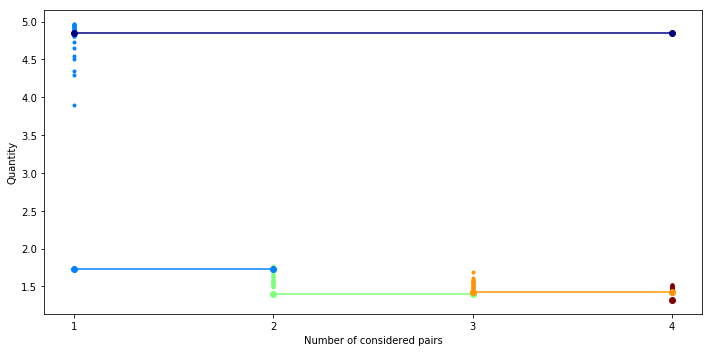

In [16]:
def plot_quantity_evolution(all_results, indep_result=None, q_func=None, figsize=(10, 5), quantity_name='Quantity'):
    """
    """
    fig, ax = plt.subplots(figsize=figsize)
    n_levels = len(all_results)
    
    # Colors of the levels and independence
    cmap = plt.get_cmap('jet')
    colors = [cmap(i) for i in np.linspace(0, 1, n_levels+1)]
    
    n_pairs = get_n_pairs(all_results)
    quantities = []
    
    for result in all_results:
        quantities.append(get_all_quantity(result, q_func=q_func))

    # Get the minimum of each level
    min_quantities = []
    for quant_lvl in quantities:
        min_quant = min(quant_lvl)
        min_quantities.append(min_quant)
        
        # Remove the minimum from the list of quantities
        quant_lvl.remove(min_quant)
    
    for lvl in range(n_levels):
        # The quantities of this level
        quant_lvl = quantities[lvl]
        # The number of results
        n_res = len(quant_lvl)
        ax.plot([n_pairs[lvl]]*n_res, quant_lvl, '.', color=colors[lvl+1])
        
    for lvl in range(n_levels):
        if n_pairs[lvl] == n_pairs[-1]:
            ax.plot(n_pairs[lvl], min_quantities[lvl], 'o', color=colors[lvl+1])
        else:
            ax.plot([n_pairs[lvl], n_pairs[lvl+1]], [min_quantities[lvl]]*2, 'o-', color=colors[lvl+1])

    if indep_result is not None:
        ax.plot([n_pairs[0], n_pairs[-1]], [indep_result.quantity]*2, '-o', color=colors[0], label='independence')
    
    ax.axis('tight')
    ax.set_xlabel('Number of considered pairs')
    ax.set_ylabel(quantity_name)
    ax.set_xticks(range(1, n_levels+1))
    fig.tight_layout()        

plot_quantity_evolution(results, indep_result)

In [83]:
def str_pairs_to_list(in_str):
    list_pairs = []
    str_pairs = in_str.split("), ")
    n_pairs = len(str_pairs)
    for str_pair in str_pairs:
        str_pair = str_pair.replace('(', '')
        str_pair = str_pair.replace(')', '')
        pairs = [int(long(p)) for p in str_pair.split(', ')]
        list_pairs.append(pairs)
    return list_pairs

for pairs in all_pairs:
    pairs = str_pairs_to_list(pairs)

In [81]:
pairs_iter = [[1, 0], [3, 2], [2, 1]]
families = np.zeros((dim, dim))
for i, j in pairs_iter:
    families[i, j] = 1

quant_estimate = ConservativeEstimate(model_func=test_func, margins=margins, families=families)
quant_estimate.vine_structure

array([[1, 0, 0, 0, 0, 0, 0, 0],
       [2, 2, 0, 0, 0, 0, 0, 0],
       [3, 3, 3, 0, 0, 0, 0, 0],
       [4, 4, 4, 4, 0, 0, 0, 0],
       [5, 5, 5, 5, 5, 0, 0, 0],
       [6, 6, 6, 6, 6, 6, 0, 0],
       [7, 7, 7, 7, 7, 7, 7, 0],
       [8, 8, 8, 8, 8, 8, 8, 8]])

In [82]:
quant_estimate.families

array([[0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0]])

In [77]:
n = 10000
res = quant_estimate.gridsearch_minimize(None, n, 'vertices', q_func=q_func)
res.min_quantity

1.5240715667480425

In [78]:
from dependence.iterative_vines import get_possible_structures, get_pair_id, get_pairs_by_levels

pairs_iter_id = [get_pair_id(dim, pair, with_plus=False) for pair in pairs_iter]
pairs_by_levels = get_pairs_by_levels(dim, pairs_iter_id)
new_vine_structure = get_possible_structures(dim, pairs_by_levels)[1]

In [86]:
quant_estimate.vine_structure = new_vine_structure
quant_estimate.vine_structure

array([[1, 0, 0, 0, 0, 0, 0, 0],
       [8, 4, 0, 0, 0, 0, 0, 0],
       [7, 8, 3, 0, 0, 0, 0, 0],
       [6, 7, 8, 2, 0, 0, 0, 0],
       [5, 6, 7, 8, 5, 0, 0, 0],
       [4, 5, 6, 7, 8, 6, 0, 0],
       [3, 2, 5, 6, 7, 8, 7, 0],
       [2, 3, 2, 5, 6, 7, 8, 8]])

In [85]:
quant_estimate.families

array([[0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0]])

In [72]:
res = quant_estimate.gridsearch_minimize(None, n, 'vertices', q_func=q_func)
res.min_quantity

4.8708017488005861